In [1]:
import sys
print("python version: ", sys.version)

import pandas as pd
print("pandas version: ", pd.__version__)

import numpy as np
print('numpy version: ', np.__version__)

import scipy as sp
print('scipy version: ', sp.__version__)

import sklearn as skl
print('sklearn version: ', skl.__version__)

import matplotlib.pyplot as plt

import seaborn as sns

import keras as ks
print('keras version: ', ks.__version__)
print('keras backend: ', ks.backend.backend())

import tensorflow as tf
print('tensorflow version: ', tf.__version__)

import theano as th
print('theano version: ', th.__version__)

import warnings
warnings.filterwarnings('ignore')


from keras import backend as K
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn.metrics import roc_curve, auc, f1_score, accuracy_score, precision_recall_curve

import os
import random

('python version: ', '2.7.15 |Anaconda, Inc.| (default, Dec 14 2018, 19:04:19) \n[GCC 7.3.0]')
('pandas version: ', u'0.23.4')
('numpy version: ', '1.15.4')
('scipy version: ', '1.1.0')
('sklearn version: ', '0.19.2')


Using TensorFlow backend.


('keras version: ', '2.1.6')
('keras backend: ', u'tensorflow')
('tensorflow version: ', '1.10.0')
('theano version: ', '0.8.2')


In [2]:
def set_keras_backend(backend):
    if K.backend() != backend:
        os.environ['KERAS_BACKEND'] = backend
        reload(K)
        assert K.backend() == backend

set_keras_backend("tensorflow")

In [3]:
excel_file = r'geriomop-data-from-egems-paper-UPDATED-COL-FIX-ATC_2-and-behavior-change-022819.tsv'
df = pd.DataFrame(pd.read_csv(excel_file, sep='\t'))
print(df.shape)

(7584, 208)


In [4]:
# Get atc codes
atc_list = []
for i in range(1, 6):
    atc_list.append(df.groupby('atc_%d' % i)['min_effective_dose_%d' % i].first())
atc_codes = pd.concat(atc_list)
atc_codes = atc_codes[~atc_codes.index.duplicated()].index.tolist()

# Fill missing min_effective_dose
atc_dic = [('N03AE01', 0.5), ('N05AB04', 15), ('N05AX13', 3), ('N05CD04', 1), ('N06AX21', 60), ('N06AX24', 20), \
           ('N06AX23', 50)]
for code, dose in atc_dic:
    for i in range(1, 6):
        df.loc[df['atc_%d' % i] == code, 'psych_sdd_%d' % i] = \
            df.loc[df['atc_%d' % i] == code, 'Psychotropic-%d-average-daily-dose' % i] / dose

# Set sdd=0 to NA
for i in range(1, 6):
    df.loc[df['psych_sdd_%d' % i] == 0, 'psych_sdd_%d' % i] = np.nan

In [5]:
# drop feature
def drop_features(df, f):
    df.drop(f, axis=1, inplace=True)

In [6]:
# one hot encoding
def one_hot_encoding(df, features, categories):
    for f, c in zip(features, categories):
        df[f] = df[f].astype('category', categories=c)
    return pd.get_dummies(df, columns=features, prefix=features)

In [7]:
# compute date difference
def date_diff(start, end):
    return (pd.to_datetime(end) - pd.to_datetime(start)) / np.timedelta64(1, 'D')

In [8]:
# generate date diff features
def generate_period(df, f):
    for start, end, period in f:
        df[period] = date_diff(df[start], df[end])
        df.drop([start, end], axis=1, inplace=True)

In [9]:
# label encoding
def label_encoding(df, features, dictionaries):
    for f, dic in zip(features, dictionaries):
        df[f] = df[f].map(dic)

In [10]:
# sin&cos transform
def col_transform(df, col, mmax, mmin, df_ref=None):
    if(mmax <= mmin):
        # for test set, if max&min not set, use training set value
        if(df_ref is not None): 
            mmax = df_ref[col].max()
            mmin = df_ref[col].max()
        else:
            mmax = df[col].max()
            mmin = df[col].min()
    angle = 0.25 * np.pi * (df[col] - mmin) / (mmax - mmin) + 0.125 * np.pi
    return (np.cos(angle), np.sin(angle))

def df_transform(df, f, df_ref=None):
    for col, mmax, mmin in f:
        df[col + '_x'], df[col + '_y'] = col_transform(df, col, mmax, mmin, df_ref)
        df[col + '_x'].fillna(0, inplace=True)
        df[col + '_y'].fillna(0, inplace=True)
        df.drop(col, axis=1, inplace=True)

In [11]:
# train test split
from sklearn.model_selection import GroupShuffleSplit
def train_test_split(df, target, groupby, radio, random_state):
    train_idx, test_idx = GroupShuffleSplit(train_size=radio, random_state=random_state).split(df, target, df[groupby]).next()
    return df.iloc[train_idx], df.iloc[test_idx], target.iloc[train_idx], target.iloc[test_idx]

In [12]:
# missing data describe
def missing_summary(df):
    missing_cnt = df.isna().sum()
    missing_data = pd.concat([missing_cnt, missing_cnt/df.shape[0]], axis=1, keys=['count', 'percentage'])
    return missing_data[missing_data['percentage'] != 0].sort_values(by='percentage', ascending=False)

In [13]:
# Drop features
f_drop = ["Blank-1", "ws-sudden-stop", "ws-sudden-stop-drugs", "ws-prolonged-psychotropics", "mds-toilet-prgm-atmptd"] + \
         ['Deleted-%d' % i for i in range(1, 13)] + ['Psychotropic-%d' % i for i in range(1, 6)] + \
         ['Psychotropic-%d-average-daily-dose' % i for i in range(1, 6)] + ["Entry-discharge-type"]

# Missing value means not relevant
f_one_hot = ["Mds-fall-2-6-months-to-admission", "Mds-fall-last-month-to-admission", "mds-pain-last-five-days", \
             "mds-delirium-scale", "mds-long-term-memory-ok", "mds-short-term-memory-ok", "mds-staff-assess-pain", \
             "recent-start-other-fall-risk-rx"] + ["mds-pressure-ulcer-stage-%d" % i for i in range(1, 5)]
cate_one_hot = [['Yes', 'No', 'Unable to answer']] * 3 + [['Yes', 'No']] * 9

f_period = [("Psychotropic-%d-Start-date" % i, 'Psychotropic-%d-End-date' % i, 'Psychotropic-%d-Period' % i) for i in range(1, 6)]

f_label = ['mds-cognitive-scale', 'mds-pain-freq-last-five-days', 'mds-pain-intensity']
dic_label = [{'Independent': 0, 'Modified Independence': 1, 'Moderately Impaired': 2, 'Severely Impaired': 3}, \
             {'Continuous': 4, 'Frequent': 3, 'Occasional': 2, 'Rare': 1, 'Unable to respond': 0}, \
             {'None': 0, 'Mild': 1, 'Moderate': 2, 'Severe': 3, 'Very severe, horrible': 4}]

f_transform = [('mds-cognitive-scale', 3, 0), ('mds-pain-freq-last-five-days', 4, 0), ('mds-pain-intensity', 4, 0)] + \
              [('Psychotropic-%d-Period' % i, 0, 0) for i in range(1, 6)]

In [14]:
# Encode features (originally) with no missing values
f_drop += ["predictor-date", "projected-date", "PPS-assessment", "Federal-assessment"]

f_period += [('episode-start-date', 'episode-end-date', 'episode-period'),\
             ('stay-start-date', 'stay-end-date', 'stay-period')]

f_label += ["cms-long-stay", "mds-stay-trans-short-to-long", "mds-antianxiety-medication", \
            "mds-antidepressant-medication", "mds-antipsychotic-medication", "mds-antibiotic-medication",
            "mds-anticoagulant-medication", "mds-diuretic-medication", \
            "mds-hypnotic-medication", "mds-behavioral-symptoms", "mds-behavioral-symptoms-to-others", \
            "mds-dehydrated", "mds-depression", "mds-fever", "mds-impaired-mobility", "mds-impaired-transfer", \
            "mds-internal-bleeding", "mds-malnutrition", "mds-no-problem-conditions", "mds-vomiting", \
            "mds-impaired-walk-in-room", "mds-impaired-walk-in-corridor", "mds-impaired-locomot-unit", \
            "mds-impaired-locomot-other", "ws-antibiotic-anticoag-coexposure", \
            "ws-psychotropic-with-not-ordered-weight-loss", \
            "ws-diuretic-adl", "ws-tramadol-antidepressant-coexposure"] + ["mds-pain-non-verbal"]
dic_label += [{'Yes': 1, 'No': 0}] * 28 + [{'None/Mild':0,'Moderate/Severe':1}]

f_one_hot += ["race", "facility", "gender", "mds-bims-summary-ranking", "ws-meclizine-psych-coexposure"]
cate_one_hot += [['White', 'Black', 'Other'], \
                 ['Sugar Creek', 'Heritage Place', 'Canterbury Place', 'Senaca Place', 'Cranberry Place'], \
                 ['Female', 'Male'], ['Intact or Moderately Intact', 'Moderate Impairment'], \
                 ['No', 'meclAndPsychStartSameR', 'meclPrecedesPsychR', 'psychPrecedesMeclR', 'meclAndPsychOlderStart']]

In [15]:
# Features need imputation
f_one_hot += ["pneumonia", "uti", "mdro", "anemia", "septicemia", "constipation", "wound", "hyponatremia", \
              "hyperkalemia", "embolisms", "alzheimers", "anxiety", "depression", "non-alz-dimentia", "bipolar", \
              "parkinsons", "psychosis", "schizophrenia", "seizure", "aphasia", "emphysema", "arthritis", "ashd", \
              "bph", "cancer", "cerebralpalsy", "stroke", "cirrhosis", "comatose", "diabetes", "dysrhythmias", "gerd", \
              "heart-failure", "hemiplegia/hemiparesis", "hepatitis", "huntingtons", "hyperlipidemia", "hyperthyroidism", \
              "hypothyroidism", "hypertension", "hypotension", "multiple-sclerosis", "neurogenic-bladder", \
              "obstructive-uropathy", "osteoporosis", "paraplegia", "ptsd", "pvd", "quadriplegia", "thyroid-disorder",\
              "tourettes", "transient-ischemic-attack", "traumatic-brain-injury", "tuberculosis", "renal-failure",\
              "mds-delirium-scale", "mds-pain-medication", "mds-received-pain-tx-non-pharm", \
              "mds-received-prn-pain-medication", "mds-conduct-staff-assessment-mental-status", \
              "mds-pressure-ulcer-prsnt", "conduct_bims", "acute_mental_change", "conduct_pain_assmnt", \
              "cane_or_crutch_past_7_days", "walker_past_7_days", "wheelchair_past_7_days", \
              "limb_prosthesis_past_7_days", "no_listed_mobility_device"] + \
              ["balance_while_standing", "balance_while_walking", "balance_turning_around", \
               "balance_toileting", "balance_bed_to_chair"] + \
              ["marital-status", "mds-entered-from", "mds-excess-weight-loss"]
cate_one_hot += [['Yes', 'No']] * 69 + \
                [["Steady at all times", "able to stabilize without assistance", \
                  "able to stabilize with assistance", "Activity did not occur"]] * 5 + \
                [["Never Married", "Married", "Widowed", "Separated", "Divorced"], \
                 ["Acute Hospital", "Psychiatric Hospital", "Another nursing home or swing bed", "Hospice", \
                  "Inpatient rehabilitation facility",
                  "Community (private home/apt., board/care, assisted living, group home)", "Other"],
                 ["Yes - prescribed", "Yes - not prescribed", "No or unknown"]]

f_label += ["mds-urinary-incontinence", "functlimit_rom_upper", "functlimit_rom_lower", "does_resident_wander"] + \
           ["cam_inattention", "cam_disorganized_thought", "cam_altered_conc", "cam_motor_retardation"]
dic_label += [{"Always continent": 0, "Occasionally incontinent": 1, "Frequently incontinent": 2,\
               "Always incontinent": 3, "Catheter - not rated": np.nan}] + \
             [{"No impairment": 0, "Impairment on one side": 1, "Impairment on both sides": 2}] * 2 + \
             [{"Behavior not exhibited": 0, "1 to 3 days": 1, "4 to 6 days": 2, "occurred daily": 3}] + \
             [{"Behavior not present": 0, "Behavior present, fluctuates": 1, "Behavior continuously present": 2}] * 4

f_transform += [("mds-urinary-incontinence", 3, 0), ("cam_inattention", 2, 0), ("cam_disorganized_thought", 2, 0), \
                ("cam_altered_conc", 2, 0), ("cam_motor_retardation", 2, 0), ("functlimit_rom_upper", 2, 0), \
                ("functlimit_rom_lower", 2, 0), ("does_resident_wander", 3, 0)]

In [16]:
# Features from new dataset
f_drop += ["min_effective_dose_%d" % i for i in range(1, 6)]

f_one_hot += ["atc_%d" % i for i in range(1, 6)]
cate_one_hot += [atc_codes] * 5

f_transform += [('psych_sdd_%d' % i, 0, 0) for i in range(1, 6)]

In [17]:
f_drop += ["min_effective_dose_%d" % i for i in range(1, 6)] + ["Psychotropic-%d-average-daily-dose" % i for i in range(1, 6)]

In [18]:
# generate target
target = df['outcome-Mds-fall-since-prior-assessment'].map({'None': 0, 'Yes': 1})
dff = df.drop(['outcome-mds-fall-no-injury', 'outcome-mds-fall-minor-injury', 'outcome-mds-fall-major-injury', \
               'outcome-Mds-fall-since-prior-assessment', 'outcome-riskmaster-fall-incident'], axis=1)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(dff, target, 'patient-id', 0.7, 0)
print 'Total number of patients: %d' % len(df.groupby('patient-id'))
print 'Number of patients in training set: %d' % len(X_train.groupby('patient-id'))

Total number of patients: 3133
Number of patients in training set: 2193


In [20]:
%%time
generate_period(X_train, f_period)
label_encoding(X_train, f_label, dic_label)
X_train_original = X_train.copy() # store value range
df_transform(X_train, f_transform)
X_train = one_hot_encoding(X_train, f_one_hot, cate_one_hot)
drop_features(X_train, f_drop)

CPU times: user 34.4 s, sys: 808 ms, total: 35.2 s
Wall time: 23.4 s


In [21]:
X_train_use = X_train.copy()

In [22]:
X_train.dtypes[X_train.dtypes == 'object'].index

Index([], dtype='object')

In [23]:
missing_summary(X_train_use)

,count,percentage


In [24]:
%%time
generate_period(X_test, f_period)
label_encoding(X_test, f_label, dic_label)
df_transform(X_test, f_transform, X_train_original)
X_test = one_hot_encoding(X_test, f_one_hot, cate_one_hot)
drop_features(X_test, f_drop)

CPU times: user 21.3 s, sys: 8 ms, total: 21.3 s
Wall time: 21.3 s


In [25]:
X_test_use = X_test.copy()

In [26]:
print(X_train.dtypes[X_train.dtypes == 'object'].index)

Index([], dtype='object')


In [27]:
missing_summary(X_test_use)

,count,percentage


In [28]:
X_train_use.shape

(5311, 524)

In [29]:
X_test_use.shape

(1512, 524)

In [30]:
idx = missing_summary(X_train_use).index.tolist()
X_train_use.drop(columns=idx, axis=1, inplace=True)
X_test_use.drop(columns=idx, axis=1, inplace=True)

In [31]:
X_train_use.shape

(5311, 524)

In [32]:
X_test_use.shape

(1512, 524)

In [33]:
# drop patient ID for basic models

from sklearn.preprocessing import MinMaxScaler

def scaler_transform(X_train_use, X_test_use):    
    scaler = MinMaxScaler(feature_range=(0, 1)).fit(X_train_use.drop('patient-id', axis=1))
    X_train_transformed = pd.DataFrame(scaler.transform(X_train_use.drop('patient-id', axis=1)), \
                                       columns=X_train_use.columns[1:], index=X_train_use.index)                                   
#     X_train_transformed['patient-id'] = X_train_use['patient-id']
    X_test_transformed = pd.DataFrame(scaler.transform(X_test_use.drop('patient-id', axis=1)), \
                                       columns=X_test_use.columns[1:], index=X_test_use.index) 
#     X_test_transformed['patient-id'] = X_test_use['patient-id']
    return X_train_transformed, X_test_transformed

In [34]:
X_train_transformed, X_test_transformed = scaler_transform(X_train_use, X_test_use)

In [35]:
X_train_transformed.shape

(5311, 523)

# Basic Model Experiment
### Prepare Test Set Features


In [36]:
from sklearn import preprocessing ## for standarScaler
import sklearn
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from pandas.core.frame import DataFrame
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import (GradientBoostingClassifier, GradientBoostingRegressor,RandomForestClassifier, RandomForestRegressor)
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import *
from sklearn.cross_validation import *
from sklearn.svm import LinearSVC

In [37]:
def find_best_f1(y_predict, y_true):
    fpr, tpr, thresholds = roc_curve(y_true, y_predict, pos_label=1) 
    max_f1, th = 0, 0
    for threshold in thresholds:
        f1 = f1_score(y_true, y_predict > threshold)
        if(f1 > max_f1):
            max_f1 = f1
            th = threshold
    return max_f1, th

In [38]:
def find_best_recall(y_predict, y_true):
    fpr, tpr, thresholds = roc_curve(y_true, y_predict, pos_label=1) 
    max_recall, th = 0, 0
    for threshold in thresholds:
        recall = recall_score(y_true, y_predict > threshold)
        if(recall > max_recall):
            max_recall = recall
            th = threshold
    return max_recall, th

In [39]:
def metrics_m_prob (model,X_train_transformed,X_test_transformed,y_train,y_test):
    Model = model.fit(X_train_transformed, y_train)
    prediction=Model.predict(X_test_transformed)
    accuracy=accuracy_score(y_test,prediction)
    precision=precision_score(y_test, prediction) # get precision score
    recall=recall_score(y_test, prediction) # get recall score
    F1=f1_score(y_test, prediction) # get F1 score

    tn, fp, fn, tp = confusion_matrix(y_test, prediction).ravel()
    specificity=float(tn) / (tn+fp) # get specificity score
    prediction_prob=Model.predict_proba(X_test_transformed)
    prediction_prob=prediction_prob[:,1]
    fpr, tpr, tresholds = roc_curve(y_test, prediction_prob)
    roc_auc = sklearn.metrics.auc(fpr,tpr) # get auroc score

    dic_=  dict([('accuracy', accuracy), ('precision', precision), ('recall', recall),('F1',F1),('specificity', specificity),('AUROC', roc_auc)])
    dic_df=pd.DataFrame(pd.Series(dic_),columns=['Score'])
    dic_df=dic_df.reset_index().rename(columns={'index':'metrics'})
    
    
    
    f1, th = find_best_f1(prediction_prob, y_test)

    ## maximum F1
    y_threshold = prediction_prob > th
    tn, fp, fn, tp = confusion_matrix(y_test, y_threshold).ravel()

    
    dic_f1= dict([('accuracy', accuracy_score(y_test, y_threshold)), ('precision', precision_score(y_test, y_threshold)), ('recall', recall_score(y_test, y_threshold)),('F1',f1_score(y_test, y_threshold)),('specificity', (float(tn) / (tn+fp)))])
    dic_df_f1=pd.DataFrame(pd.Series(dic_f1),columns=['Score'])
    dic_df_f1=dic_df_f1.reset_index().rename(columns={'index':'metrics'})
   
    return dic_df,dic_df_f1,th


In [40]:
def metrics_m_pre (model,X_train_transformed,X_test_transformed,y_train,y_test):
    Model = model.fit(X_train_transformed, y_train)
    prediction=Model.predict(X_test_transformed)
    accuracy=accuracy_score(y_test,prediction)
    precision=precision_score(y_test, prediction) # get precision score
    recall=recall_score(y_test, prediction) # get recall score
    F1=f1_score(y_test, prediction) # get F1 score

    tn, fp, fn, tp = confusion_matrix(y_test, prediction).ravel()
    specificity=float(tn) / (tn+fp) # get specificity score
#     prediction_prob=Model.predict_proba(X_test_transformed)
#     prediction_prob=prediction_prob[:,1]
    fpr, tpr, tresholds = roc_curve(y_test, prediction)
    roc_auc = sklearn.metrics.auc(fpr,tpr) # get auroc score

    dic_=  dict([('accuracy', accuracy), ('precision', precision), ('recall', recall),('F1',F1),('specificity', specificity),('AUROC', roc_auc)])
    dic_df=pd.DataFrame(pd.Series(dic_),columns=['Score'])
    dic_df=dic_df.reset_index().rename(columns={'index':'metrics'})
    
    
    
    f1, th = find_best_f1(prediction, y_test)

    ## maximum F1
    y_threshold = prediction> th
    tn, fp, fn, tp = confusion_matrix(y_test, y_threshold).ravel()

    
    dic_f1= dict([('accuracy', accuracy_score(y_test, y_threshold)), ('precision', precision_score(y_test, y_threshold)), ('recall', recall_score(y_test, y_threshold)),('F1',f1_score(y_test, y_threshold)),('specificity', (float(tn) / (tn+fp)))])
    dic_df_f1=pd.DataFrame(pd.Series(dic_f1),columns=['Score'])
    dic_df_f1=dic_df_f1.reset_index().rename(columns={'index':'metrics'})
   
    return dic_df,dic_df_f1,th


In [41]:
def AUROC_Tain_prob(model,X_train_transformed,y_train):
    # training set
    Model = model.fit(X_train_transformed, y_train)
    # prediction=Model.predict(X_train_transformed)
    prediction_prob=Model.predict_proba(X_train_transformed)
    prediction_prob=prediction_prob[:,1]


    fpr, tpr, tresholds = roc_curve(y_train, prediction_prob)
    roc_auc = sklearn.metrics.auc(fpr,tpr) # get auroc score 
    return roc_auc

In [42]:
def AUROC_Tain_pre(model,X_train_transformed,y_train):
    # training set
    Model = model.fit(X_train_transformed, y_train)
    prediction=Model.predict(X_train_transformed)
#     prediction_prob=Model.predict_proba(X_train_transformed)
#     prediction_prob=prediction_prob[:,1]


    fpr, tpr, tresholds = roc_curve(y_train, prediction)
    roc_auc = sklearn.metrics.auc(fpr,tpr) # get auroc score 
    return roc_auc

In [51]:
def plot_roc_curve(fpr, tpr):
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % auc(fpr, tpr))
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()

In [52]:
def drawAUROC (model,figureName):
    Model = model.fit(X_train_transformed, y_train)
    prediction_prob=Model.predict_proba(X_test_transformed)
    prediction_prob=prediction_prob[:,1]
    fpr, tpr, tresholds = roc_curve(y_test, prediction_prob)

    f1, th = find_best_f1(prediction_prob, y_test)
    y_threshold = prediction_prob > th
    tn, fp, fn, tp = confusion_matrix(y_test, y_threshold).ravel()
    recall=recall_score(y_test, y_threshold)
    specificity=(float(tn) / (tn+fp))


    import csv 
    fpr, tpr, thresholds = roc_curve(y_test, prediction_prob, pos_label=1)
    plot_roc_curve(fpr, tpr)
    with open(figureName, "w") as writeFile:
        writer  = csv.writer(writeFile)
        writer.writerows([fpr, tpr, [recall, 1-specificity]])

In [71]:
from sklearn.calibration import calibration_curve
import csv 

def calibPlots (model,figureName):
    Model = model.fit(X_train_transformed, y_train)
    prediction_prob=Model.predict_proba(X_test_transformed)
    prediction_prob=prediction_prob[:,1]
    fraction_of_positives, mean_predicted_value = calibration_curve(y_test, prediction_prob, n_bins=10)
    with open(figureName, "w") as writeFile:
        writer  = csv.writer(writeFile)
        writer.writerows([fraction_of_positives, mean_predicted_value])

    plt.figure()
    plt.plot(mean_predicted_value, fraction_of_positives, 's-')
    plt.plot([0, 1], [0, 1], '--', color='gray')
    plt.show()


In [76]:
from sklearn.calibration import calibration_curve
import csv 

def calibPlots_normalized (model,figureName):
    Model = model.fit(X_train_transformed, y_train)
    prediction_prob=Model.predict_proba(X_test_transformed)
    prediction_prob=prediction_prob[:,1]
    fraction_of_positives, mean_predicted_value = calibration_curve(y_test, prediction_prob, normalize=True, n_bins=10)
    with open(figureName, "w") as writeFile:
        writer  = csv.writer(writeFile)
        writer.writerows([fraction_of_positives, mean_predicted_value])

    plt.figure()
    plt.plot(mean_predicted_value, fraction_of_positives, 's-')
    plt.plot([0, 1], [0, 1], '--', color='gray')
    plt.show()

# tuning hyperparameters for SVM based on "roc_auc"

In [43]:
from sklearn.model_selection import GridSearchCV
from sklearn.learning_curve import validation_curve
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC

# tuning hyperparameters for Logistic regression based on "roc_auc"

In [167]:
parameters={'C':[0.25,0.5, 0.75, 1,1.5], 'solver':('liblinear','sag','newton-cg', 'lbfgs')}
model = LogisticRegression(penalty='l2',class_weight='balanced',random_state=100)
clf = GridSearchCV(model, parameters, n_jobs=-1,scoring='roc_auc', cv=5)
clf.fit(X_train_transformed, y_train)
print('The parameters of the best model are: ')
print(clf.best_params_)
y_pred = clf.predict(X_test_transformed)
print(classification_report(y_test, y_pred))

The parameters of the best model are: 
{'C': 0.25, 'solver': 'liblinear'}
             precision    recall  f1-score   support

          0       0.87      0.73      0.79      1229
          1       0.31      0.52      0.39       283

avg / total       0.76      0.69      0.72      1512



In [239]:

# training set
Model = LogisticRegression(penalty='l2',class_weight='balanced',C=0.25, solver='liblinear',random_state=100).fit(X_train_transformed, y_train)
# prediction=Model.predict(X_train_transformed)
prediction_prob=Model.predict_proba(X_train_transformed)
prediction_prob=prediction_prob[:,1]


fpr, tpr, tresholds = roc_curve(y_train, prediction_prob)
roc_auc = sklearn.metrics.auc(fpr,tpr) # get auroc score 

In [240]:
roc_auc ## AUROC score of 70% training set

0.7797980684686929

In [241]:
# test set
clf_model=LogisticRegression(penalty='l2',class_weight='balanced',C=0.25, solver='liblinear',random_state=100)
results=metrics_m_prob(clf_model,X_train_transformed,X_test_transformed,y_train,y_test)

In [242]:
results[0]

,metrics,Score
0,AUROC,0.679636
1,F1,0.385827
2,accuracy,0.690476
3,precision,0.306889
4,recall,0.519435
5,specificity,0.729862


In [243]:
results[1]

,metrics,Score
0,F1,0.394036
1,accuracy,0.623677
2,precision,0.282012
3,recall,0.653710
4,specificity,0.616762


In [244]:
results[2]

0.4251635423444212

### LR AUROC curve

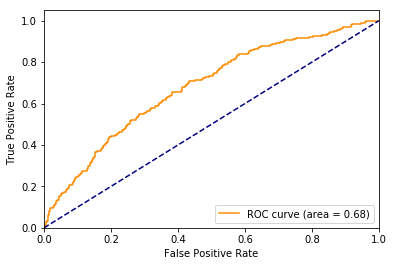

In [53]:
model=LogisticRegression(penalty='l2',class_weight='balanced',C=0.25, solver='liblinear',random_state=100) # LR
drawAUROC(model,'LR_exp_2.csv')

### LR calibration plots without normalzied

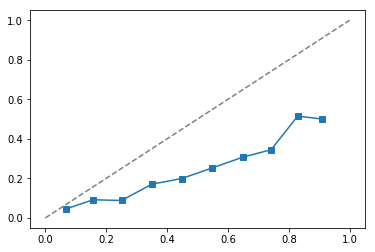

In [72]:
model=LogisticRegression(penalty='l2',class_weight='balanced',C=0.25, solver='liblinear',random_state=100)
calibPlots(model,'LR_exp_2_cal.csv')

### LR calibration plots with normalzied

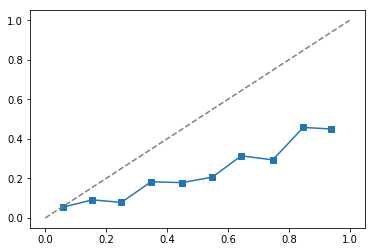

In [77]:
model=LogisticRegression(penalty='l2',class_weight='balanced',C=0.25, solver='liblinear',random_state=100)
calibPlots_normalized(model,'LR_exp_2_NorCal.csv')

# tuning hyperparameters for randomForest Tree based on "roc_auc"¶

### RF without aggressive hyper-parameters 

In [45]:
parameters={'criterion':('gini','entropy'),'n_estimators':range(11,201,10),'max_depth':range(1,11,2), 'max_leaf_nodes':range(5,30,5)}
model = RandomForestClassifier(class_weight='balanced',random_state=100)
clf = GridSearchCV(model, parameters,n_jobs=-1,scoring='roc_auc', cv=5)
clf.fit(X_train_transformed, y_train)
print('The parameters of the best model are: ')
print(clf.best_params_)
y_pred = clf.predict(X_test_transformed)
print(classification_report(y_test, y_pred))

The parameters of the best model are: 
{'n_estimators': 191, 'max_leaf_nodes': 25, 'criterion': 'gini', 'max_depth': 7}
             precision    recall  f1-score   support

          0       0.86      0.77      0.81      1229
          1       0.31      0.46      0.37       283

avg / total       0.76      0.71      0.73      1512



In [46]:
clf_model=RandomForestClassifier(class_weight='balanced',n_estimators=191,max_leaf_nodes=25,criterion='gini',max_depth=7,random_state=100)
results=metrics_m_prob(clf_model,X_train_transformed,X_test_transformed,y_train,y_test)

In [47]:
results[0]

,metrics,Score
0,AUROC,0.696507
1,F1,0.373563
2,accuracy,0.711640
3,precision,0.314770
4,recall,0.459364
5,specificity,0.769731


In [48]:
results[1]

,metrics,Score
0,F1,0.404558
1,accuracy,0.585317
2,precision,0.276623
3,recall,0.752650
4,specificity,0.546786


In [50]:
results[2]

0.40438596373112257

In [49]:
clf_model=RandomForestClassifier(class_weight='balanced',n_estimators=191,max_leaf_nodes=25,criterion='gini',max_depth=7,random_state=100)
# training set
AUROC_Tain_prob (clf_model,X_train_transformed,y_train)  ## return the training set AUROC score

0.7904935584945892

In [ ]:
########################################

### RF using aggressive hyper-parameters with final results shown in AMIA paper

In [179]:
parameters={'criterion':('gini','entropy'),'n_estimators':[200,800,1000,1500,2000,2500,3000],'max_depth':[10,20,30,50,65,80], 'max_leaf_nodes':[100,150,180,200,250]}
model = RandomForestClassifier(class_weight='balanced',random_state=100)
clf = GridSearchCV(model, parameters,n_jobs=-1,scoring='roc_auc', cv=5)
clf.fit(X_train_transformed, y_train)
print('The parameters of the best model are: ')
print(clf.best_params_)
y_pred = clf.predict(X_test_transformed)
print(classification_report(y_test, y_pred))

The parameters of the best model are: 
{'n_estimators': 1500, 'max_leaf_nodes': 250, 'criterion': 'gini', 'max_depth': 50}
             precision    recall  f1-score   support

          0       0.83      0.95      0.88      1229
          1       0.39      0.15      0.22       283

avg / total       0.75      0.80      0.76      1512



In [245]:
clf_model=RandomForestClassifier(class_weight='balanced',n_estimators=1500,max_leaf_nodes=250,criterion='gini',max_depth=50,random_state=100)
results=metrics_m_prob(clf_model,X_train_transformed,X_test_transformed,y_train,y_test)

In [246]:
results[0]

,metrics,Score
0,AUROC,0.706262
1,F1,0.215385
2,accuracy,0.797619
3,precision,0.392523
4,recall,0.148410
5,specificity,0.947111


In [247]:
results[1]

,metrics,Score
0,F1,0.409613
1,accuracy,0.626323
2,precision,0.290801
3,recall,0.692580
4,specificity,0.611066


In [248]:
results[2]

0.2996014943306514

In [226]:
# training set
Model = RandomForestClassifier(class_weight='balanced',n_estimators=1500,max_leaf_nodes=250,criterion='gini',max_depth=50,random_state=100).fit(X_train_transformed, y_train)
# prediction=Model.predict(X_train_transformed)
prediction_prob=Model.predict_proba(X_train_transformed)
prediction_prob=prediction_prob[:,1]


fpr, tpr, tresholds = roc_curve(y_train, prediction_prob)
roc_auc = sklearn.metrics.auc(fpr,tpr) # get auroc score 
roc_auc 

0.9755467268128695

### Random Forest Tree AUROC curve

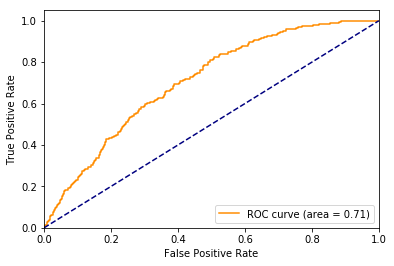

In [55]:
model=RandomForestClassifier(class_weight='balanced',n_estimators=1500,max_leaf_nodes=250,criterion='gini',max_depth=50,random_state=100) # RF
drawAUROC(model,'RF_exp_2.csv')

### Random Forest Tree calibration plots without normalzied

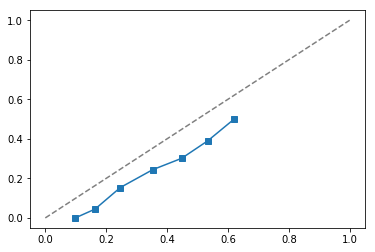

In [73]:
model=RandomForestClassifier(class_weight='balanced',n_estimators=1500,max_leaf_nodes=250,criterion='gini',max_depth=50,random_state=100) # RF
calibPlots(model,'RF_exp_2_cal.csv')

### Random Forest Tree calibration plots withnormalzied

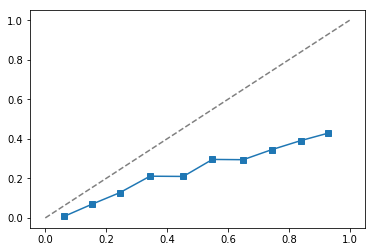

In [78]:
model=RandomForestClassifier(class_weight='balanced',n_estimators=1500,max_leaf_nodes=250,criterion='gini',max_depth=50,random_state=100) 
calibPlots_normalized(model,'RF_exp_2_NorCal.csv')

# tuning hyperparameters for MultinomialNB based on "roc_auc"

In [127]:
from sklearn.naive_bayes import MultinomialNB
parameters={'fit_prior':[True,False],'alpha':[0.3,0.4,0.5,0.6,0.7,0.8,1,1.2,1.5]}
model = MultinomialNB()
clf = GridSearchCV(model, parameters,n_jobs=-1,scoring='roc_auc', cv=5)
clf.fit(X_train_transformed, y_train)
print('The parameters of the best model are: ')
print(clf.best_params_)
y_pred = clf.predict(X_test_transformed)
print(classification_report(y_test, y_pred))


The parameters of the best model are: 
{'alpha': 0.6, 'fit_prior': True}
             precision    recall  f1-score   support

          0       0.84      0.86      0.85      1229
          1       0.33      0.30      0.31       283

avg / total       0.75      0.75      0.75      1512



In [249]:
clf_model = MultinomialNB(alpha=0.6,fit_prior=True)
results=metrics_m_prob(clf_model,X_train_transformed,X_test_transformed,y_train,y_test)

In [250]:
results[0]

,metrics,Score
0,AUROC,0.672425
1,F1,0.312500
2,accuracy,0.752646
3,precision,0.325670
4,recall,0.300353
5,specificity,0.856794


In [251]:
results[1]

,metrics,Score
0,F1,0.391978
1,accuracy,0.558862
2,precision,0.264128
3,recall,0.759717
4,specificity,0.512612


In [252]:
results[2]

0.012026457755169738

In [227]:
# training set
Model = MultinomialNB(alpha=0.6,fit_prior=True).fit(X_train_transformed, y_train)
# prediction=Model.predict(X_train_transformed)
prediction_prob=Model.predict_proba(X_train_transformed)
prediction_prob=prediction_prob[:,1]


fpr, tpr, tresholds = roc_curve(y_train, prediction_prob)
roc_auc = sklearn.metrics.auc(fpr,tpr) # get auroc score 
roc_auc 

0.7090545426571274

# tuning hyperparameters for linearSVC based on "roc_auc"

In [180]:
parameters={'loss':('hinge','squared_hinge'),'C':[0.00001,0.0001,0.001,0.01,0.05,0.075]}
model = LinearSVC(class_weight='balanced',penalty='l2',random_state=100)
clf = GridSearchCV(model, parameters,scoring='roc_auc', cv=5)
clf.fit(X_train_transformed, y_train)
print('The parameters of the best model are: ')
print(clf.best_params_)
y_pred = clf.predict(X_test_transformed)
print(classification_report(y_test, y_pred))

The parameters of the best model are: 
{'loss': 'squared_hinge', 'C': 0.001}
             precision    recall  f1-score   support

          0       0.86      0.77      0.81      1229
          1       0.32      0.48      0.38       283

avg / total       0.76      0.71      0.73      1512



In [181]:
parameters={'C':[0.0001,0.001,0.01]}
model = LinearSVC(class_weight='balanced',penalty='l1',loss='squared_hinge',dual=False,random_state=100)
clf = GridSearchCV(model, parameters,scoring='roc_auc',cv=5)
clf.fit(X_train_transformed, y_train)
print('The parameters of the best model are: ')
print(clf.best_params_)
y_pred = clf.predict(X_test_transformed)
print(classification_report(y_test, y_pred))

The parameters of the best model are: 
{'C': 0.01}
             precision    recall  f1-score   support

          0       0.87      0.73      0.79      1229
          1       0.30      0.52      0.38       283

avg / total       0.76      0.69      0.71      1512



In [202]:
clf_model=LinearSVC(class_weight='balanced',penalty='l1',loss='squared_hinge',C=0.01,dual=False,random_state=100)
results=metrics_m_pre(clf_model,X_train_transformed,X_test_transformed,y_train,y_test)

In [203]:
results[0]

,metrics,Score
0,AUROC,0.621254
1,F1,0.381699
2,accuracy,0.687169
3,precision,0.302905
4,recall,0.515901
5,specificity,0.726607


In [204]:
results[1]

,metrics,Score
0,F1,0.381699
1,accuracy,0.687169
2,precision,0.302905
3,recall,0.515901
4,specificity,0.726607


In [229]:
# training set
Model = LinearSVC(class_weight='balanced',penalty='l1',loss='squared_hinge',C=0.01,dual=False,random_state=100).fit(X_train_transformed, y_train)
prediction=Model.predict(X_train_transformed)
# prediction_prob=Model.predict_proba(X_train_transformed)
# prediction_prob=prediction_prob[:,1]


fpr, tpr, tresholds = roc_curve(y_train, prediction)
roc_auc = sklearn.metrics.auc(fpr,tpr) # get auroc score 
roc_auc

0.6726238261838924

# tuning hyperparameters for Decision Tree based on "roc_auc"

In [182]:
parameters={'criterion':('gini','entropy'),'max_depth':[None,1,2,3,4,5,6,7,8,9,50,500,1000,5000], 'max_leaf_nodes':[None,2,3,5,6,7,8,9,10,100,200,300,500]}
model = DecisionTreeClassifier(class_weight='balanced',random_state=100)
clf = GridSearchCV(model, parameters,scoring='roc_auc',cv=5)
clf.fit(X_train_transformed, y_train)
print('The parameters of the best model are: ')

print(clf.best_params_)
y_pred = clf.predict(X_test_transformed)
print(classification_report(y_test, y_pred))

The parameters of the best model are: 
{'max_leaf_nodes': 8, 'criterion': 'entropy', 'max_depth': None}
             precision    recall  f1-score   support

          0       0.86      0.68      0.76      1229
          1       0.28      0.53      0.36       283

avg / total       0.75      0.65      0.68      1512



In [253]:
clf_model=DecisionTreeClassifier(class_weight='balanced',max_leaf_nodes=8,criterion='entropy',max_depth=None,random_state=100)
results=metrics_m_prob(clf_model,X_train_transformed,X_test_transformed,y_train,y_test)

In [254]:
results[0]

,metrics,Score
0,AUROC,0.645069
1,F1,0.363418
2,accuracy,0.650132
3,precision,0.275547
4,recall,0.533569
5,specificity,0.676973


In [255]:
results[1]

,metrics,Score
0,F1,0.368818
1,accuracy,0.501984
2,precision,0.241758
3,recall,0.777385
4,specificity,0.438568


In [256]:
results[2]

0.23250385673083415

In [231]:
# training set
Model = DecisionTreeClassifier(class_weight='balanced',max_leaf_nodes=8,criterion='entropy',max_depth=None,random_state=100).fit(X_train_transformed, y_train)
# prediction=Model.predict(X_train_transformed)
prediction_prob=Model.predict_proba(X_train_transformed)
prediction_prob=prediction_prob[:,1]


fpr, tpr, tresholds = roc_curve(y_train, prediction_prob)
roc_auc = sklearn.metrics.auc(fpr,tpr) # get auroc score 
roc_auc

0.7125150495295296

### Decision Tree AUROC curve

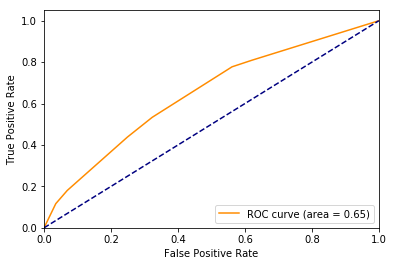

In [54]:
model=DecisionTreeClassifier(class_weight='balanced',max_leaf_nodes=8,criterion='entropy',max_depth=None,random_state=100) # DT
drawAUROC(model,'DT_exp_2.csv')

### Decision Tree calibration plots without normalzied

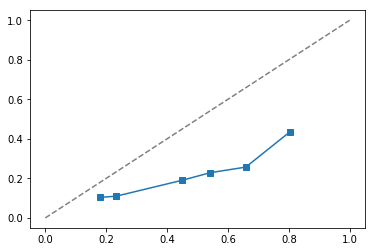

In [74]:
model=DecisionTreeClassifier(class_weight='balanced',max_leaf_nodes=8,criterion='entropy',max_depth=None,random_state=100)
calibPlots(model,'DT_exp_2_cal.csv')

### Decision Tree calibration plots with normalzied

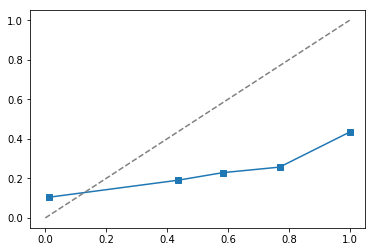

In [79]:
model=DecisionTreeClassifier(class_weight='balanced',max_leaf_nodes=8,criterion='entropy',max_depth=None,random_state=100)
calibPlots_normalized(model,'DT_exp_2_NorCal.csv')

# tuning hyperparameters for SGD Classifier based on "roc_auc"

In [183]:
### SGBClassifier

parameters={'learning_rate':('constant','optimal','invscaling'),'eta0':(0.001,0.0001,0.00001),'loss':('modified_huber','squared_loss','squared_hinge','perceptron'),'penalty':('l2', 'l1', 'elasticnet')}
model = SGDClassifier(class_weight='balanced',random_state=100)
clf = GridSearchCV(model, parameters, n_jobs=-1,scoring='roc_auc', cv=5)
clf.fit(X_train_transformed_1, y_train)
print('The parameters of the best model are: ')
print(clf.best_params_)
y_pred = clf.predict(X_test_transformed_1)
print(classification_report(y_test, y_pred))

The parameters of the best model are: 
{'penalty': 'elasticnet', 'loss': 'squared_loss', 'learning_rate': 'constant', 'eta0': 1e-05}
             precision    recall  f1-score   support

          0       0.87      0.69      0.77      1229
          1       0.30      0.56      0.39       283

avg / total       0.76      0.67      0.70      1512



In [210]:
# clf_model=SGDClassifier(class_weight='balanced',penalty='elasticnet',loss='squared_loss',learning_rate='constant',eta0=1e-05,random_state=100)
# results=metrics_m_pre(clf_model,X_train_transformed,X_test_transformed,y_train,y_test)

In [211]:
# results[0]

,metrics,Score
0,AUROC,0.602727
1,F1,0.357864
2,accuracy,0.705688
3,precision,0.302439
4,recall,0.438163
5,specificity,0.767290


In [184]:
### SGBClassifier

parameters={'learning_rate':('constant','optimal','invscaling'),'eta0':(0.001,0.0001,0.00001),'loss':('modified_huber','squared_loss','squared_hinge','perceptron'),'penalty':('l2', 'l1', 'elasticnet')}
model = SGDClassifier(class_weight='balanced',random_state=100)
clf = GridSearchCV(model, parameters, n_jobs=-1,scoring='roc_auc', cv=5)
clf.fit(X_train_transformed, y_train)
print('The parameters of the best model are: ')
print(clf.best_params_)
y_pred = clf.predict(X_test_transformed)
print(classification_report(y_test, y_pred))

The parameters of the best model are: 
{'penalty': 'l2', 'loss': 'squared_loss', 'learning_rate': 'constant', 'eta0': 0.0001}
             precision    recall  f1-score   support

          0       0.84      0.87      0.85      1229
          1       0.34      0.30      0.32       283

avg / total       0.75      0.76      0.75      1512



In [257]:
clf_model=SGDClassifier(class_weight='balanced',penalty='l2',loss='squared_loss',learning_rate='constant',eta0=0.0001,random_state=100)
results=metrics_m_pre(clf_model,X_train_transformed_1,X_test_transformed_1,y_train,y_test)

In [258]:
results[0]

,metrics,Score
0,AUROC,0.619766
1,F1,0.379845
2,accuracy,0.682540
3,precision,0.299389
4,recall,0.519435
5,specificity,0.720098


In [259]:
results[1]

,metrics,Score
0,F1,0.379845
1,accuracy,0.682540
2,precision,0.299389
3,recall,0.519435
4,specificity,0.720098


In [260]:
results[2]

0

In [233]:
# training set
Model = SGDClassifier(class_weight='balanced',penalty='l2',loss='squared_loss',learning_rate='constant',eta0=0.0001,random_state=100).fit(X_train_transformed, y_train)
prediction=Model.predict(X_train_transformed)
# prediction_prob=Model.predict_proba(X_train_transformed)
# prediction_prob=prediction_prob[:,1]


fpr, tpr, tresholds = roc_curve(y_train, prediction)
roc_auc = sklearn.metrics.auc(fpr,tpr) # get auroc score 
roc_auc

0.6640104925485065

# tuning hyperparameters for GrandientBoosting based on "roc_auc"

In [81]:
### 
# parameters={'max_depth':range(2,16,2), 'min_samples_split':range(30,500,40),'learning_rate':(0.0001,0.001,0.01,1e-05,0.1),'subsample':(0.1,0.2,0.3,0.4,0.5,0.6,0.8)}
# model = GradientBoostingClassifier(random_state=100)
# clf = GridSearchCV(model, parameters, n_jobs=-1,scoring='roc_auc', cv=5)
# clf.fit(X_train_transformed, y_train)
# print('The parameters of the best model are: ')
# print(clf.best_params_)
# y_pred = clf.predict(X_test_transformed)
# print(classification_report(y_test, y_pred))

In [ ]:
## final model

In [220]:
### 
parameters={'max_depth':range(2,14,2), 'min_samples_split':range(200,1001,200),'learning_rate':(0.01,1e-05,0.1),'subsample':(0.3,0.8,0.9)}
model = GradientBoostingClassifier(random_state=100)
clf = GridSearchCV(model, parameters, n_jobs=-1,scoring='roc_auc', cv=5)
clf.fit(X_train_transformed, y_train)
print('The parameters of the best model are: ')
print(clf.best_params_)
y_pred = clf.predict(X_test_transformed)
print(classification_report(y_test, y_pred))

The parameters of the best model are: 
{'min_samples_split': 200, 'subsample': 0.3, 'learning_rate': 0.01, 'max_depth': 10}
             precision    recall  f1-score   support

          0       0.81      1.00      0.90      1229
          1       0.00      0.00      0.00       283

avg / total       0.66      0.81      0.73      1512



In [59]:
clf_model=GradientBoostingClassifier(min_samples_split=200,subsample=0.3,learning_rate=0.01,max_depth=10,random_state=100)
results=metrics_m_prob(clf_model,X_train_transformed,X_test_transformed,y_train,y_test)

In [60]:
results[0]

,metrics,Score
0,AUROC,0.700488
1,F1,0.000000
2,accuracy,0.812831
3,precision,0.000000
4,recall,0.000000
5,specificity,1.000000


In [61]:
results[1]

,metrics,Score
0,F1,0.419753
1,accuracy,0.720238
2,precision,0.343049
3,recall,0.540636
4,specificity,0.761595


In [62]:
results[2]

0.190341156924584

In [63]:
Model = GradientBoostingClassifier(min_samples_split=200,subsample=0.3,learning_rate=0.01,max_depth=10,random_state=100).fit(X_train_transformed, y_train)
# prediction=Model.predict(X_train_transformed)
prediction_prob=Model.predict_proba(X_train_transformed)
prediction_prob=prediction_prob[:,1]


fpr, tpr, tresholds = roc_curve(y_train, prediction_prob)
roc_auc = sklearn.metrics.auc(fpr,tpr) # get auroc score 
roc_auc

0.8217662566776018

### AUROC plots for GrandientBoostingClassifier (GDBT)

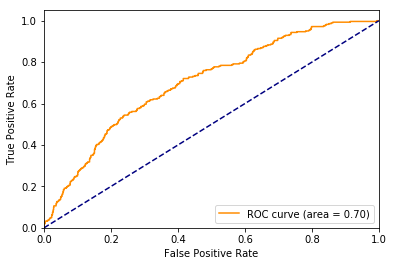

In [64]:
model=GradientBoostingClassifier(min_samples_split=200,subsample=0.3,learning_rate=0.01,max_depth=10,random_state=100)
drawAUROC(model,'GDBT_exp_2.csv')

### GrandientBoostingClassifier (GDBT) calibration plots without normalzied

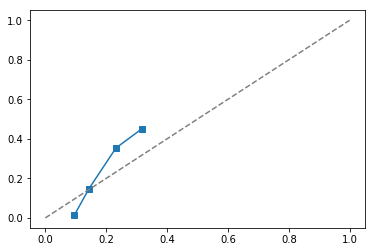

In [75]:
model=GradientBoostingClassifier(min_samples_split=200,subsample=0.3,learning_rate=0.01,max_depth=10,random_state=100)
calibPlots(model,'GDBT_exp_2_cal.csv')

### GrandientBoostingClassifier (GDBT) calibration plots with normalzied

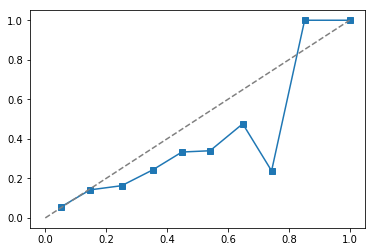

In [80]:
model=GradientBoostingClassifier(min_samples_split=200,subsample=0.3,learning_rate=0.01,max_depth=10,random_state=100)
calibPlots_normalized(model,'GDBT__exp_2_NorCal.csv')

# GaussianNB

In [265]:
clf_model=GaussianNB()
results=metrics_m_prob(clf_model,X_train_transformed,X_test_transformed,y_train,y_test)

In [266]:
results[0]

,metrics,Score
0,AUROC,0.498872
1,F1,0.312319
2,accuracy,0.213624
3,precision,0.186722
4,recall,0.954064
5,specificity,0.043124


In [267]:
results[1]

,metrics,Score
0,F1,0.313613
1,accuracy,0.209656
2,precision,0.187243
3,recall,0.964664
4,specificity,0.035801


In [268]:
results[2]

1.100394335994655e-24

In [236]:
# training set
Model = GaussianNB().fit(X_train_transformed, y_train)
# prediction=Model.predict(X_train_transformed)
prediction_prob=Model.predict_proba(X_train_transformed)
prediction_prob=prediction_prob[:,1]


fpr, tpr, tresholds = roc_curve(y_train, prediction_prob)
roc_auc = sklearn.metrics.auc(fpr,tpr) # get auroc score 
roc_auc

0.5314603010991408